# COMP4318 & 5318 - Machine Learning and Data Mining: Assignment-2

##  1. Environment Setup

In [66]:
import tensorflow as tf
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [67]:
# reset models for each executaion 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Define any necessary utility or helper functions (e.g., for plotting, optimization, etc.) if applicable.

In [69]:
def flip_and_rotate(image):
    # Flip the image horizontally (left-to-right)
    flipped_image = np.fliplr(image)
    
    # Rotate the image 90 degrees anti-clockwise
    rotated_image = np.rot90(flipped_image)
    
    return rotated_image

In [70]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""

    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)


    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

    for row in range(n_rows):
        for col in range(n_cols):

            # Get next index of image
            index = n_cols * row + col

            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')

    plt.show()

In [71]:
def plot_accur(accuracies, name):
    # Plot the accuracies
    accuracies.plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0.55, 0.9)
    plt.xlabel('Epoch')
    plt.title(name)
    plt.show()

In [126]:
# plot the bar figure
def plot_model_metric(models, data, data_name):

    # Convert array of data into dataframe for easier plotting
    data_dict = {'Model': models, data_name: data}
    df = pd.DataFrame(data_dict)

    # set the style of visualization
    sns.set(style="whitegrid")

    sns.barplot(x='Model', y = data_name, hue = df.Model, data = df, palette = "Blues_d", dodge = False, width = 0.5)

    # # Set figure title and labels
    # ax.set_title('Model {} Comparison'.format(data_name), fontsize = 16)
    # ax.set_xlabel(None)
    # ax.set_ylabel(data_name, fontsize = 12)
    
    # # Loop through data and add annotations
    # for i, val in enumerate(df[data_name]):
    #     ax.text(i, val, f"{val:.2f}", ha = 'center', va = 'bottom', fontsize = 10) # adjust offset and alignment

### Create a mapping from label number to corresponding character

In [76]:
label_to_char_map = {i: chr(i + 48) for i in range(10)}  # Digits (0-9)
label_to_char_map.update({i + 10: chr(i + 65) for i in range(26)})  # Uppercase letters (A-Z)
label_to_char_map.update({i + 36: chr(i + 97) for i in range(26)})  # Lowercase letters (a-z)

# Function to get the character from a label number
def get_character_from_label(label):
    return label_to_char_map.get(label, "Unknown Label")

def get_all_labels():
    return [get_character_from_label(i) for i in range(62)]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [152]:
def plot_confusion(matrix, name):
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=False, fmt='d', cmap='Blues', 
                xticklabels=get_all_labels(), 
                yticklabels=get_all_labels(),
                annot_kws={"size": 10},  
                cbar_kws={'label': 'Count'})  
    
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
    plt.yticks(rotation=0, fontsize=10)  
    plt.title(f'Confusion Matrix - {name}', fontsize=14)  
    plt.ylabel('True Label', fontsize=12)  
    plt.xlabel('Predicted Label', fontsize=12)  
    plt.show()

## 2. Loading dataset

In [73]:
# Load the EMNIST dataset
# Define the path to your .pkl file
train_file_path = '/Users/poyu/Desktop/COMP5318 - Machine Learning and Data Mining/A2/ML&DM assign2/EMNIST_Byclass_Small/emnist_train.pkl'
test_file_path = '/Users/poyu/Desktop/COMP5318 - Machine Learning and Data Mining/A2/ML&DM assign2/EMNIST_Byclass_Small/emnist_test.pkl'

# Open and load the .pkl file
with open(train_file_path, 'rb') as file:
    dataset_train = pickle.load(file)

with open(test_file_path, 'rb') as file:
    dataset_test = pickle.load(file)

In [74]:
# Separate training data and labels
X_train = dataset_train['data']
y_train = dataset_train['labels']

# Separate test data and labels
X_test = dataset_test['data']
y_test = dataset_test['labels']

# Check the shapes of the data and labels
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(y_train)

Training data shape: (100000, 28, 28)
Training labels shape: (100000,)
[50 20  5 ...  0  2 40]


In [75]:
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Test data shape: (20000, 28, 28)
Test labels shape: (20000,)


## 3. Data Preprocessing

In [77]:
# X_train and X_test are loaded with shapes (100000, 28, 28)

# Apply flip and rotation to all training images
X_train = np.array([flip_and_rotate(img.reshape(28, 28)) for img in X_train])

# Apply flip and rotation to all test images
X_test = np.array([flip_and_rotate(img.reshape(28, 28)) for img in X_test])

# Reshape to add the channel dimension for CNN input
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [78]:
# Scale the data to the range 0-1 (Normalization)
X_train = X_train / 255.
X_test = X_test / 255.

 ## 4. Displaying random training and testing images

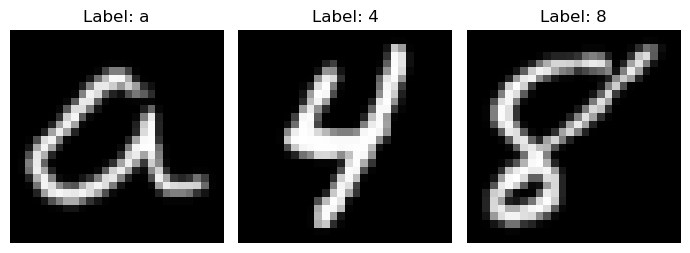

In [79]:
# Number of random images to display
num_images = 3

# Randomly select 3 unique indices from the training data
random_indices = np.random.choice(X_train.shape[0], num_images, replace=False)

# Set up the figure for displaying images
plt.figure(figsize=(7, 4))

# Loop through the selected indices and display the images
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')  # Reshape for display
    plt.title(f'Label: {get_character_from_label(y_train[idx])}')  # Show the corresponding label
    plt.axis('off')  # Turn off axis

# Show the images
plt.tight_layout()
plt.show()

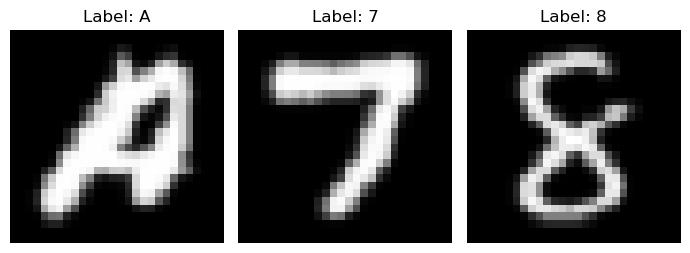

In [80]:
# Number of random images to display
num_images = 3

# Randomly select 3 unique indices from the testing data
random_indices = np.random.choice(X_test.shape[0], num_images, replace=False)

# Set up the figure for displaying images
plt.figure(figsize=(7, 4))

# Loop through the selected indices and display the images
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')  # Reshape for display
    plt.title(f'Label: {get_character_from_label(y_test[idx])}')  # Show the corresponding label
    plt.axis('off')  # Turn off axis

# Show the images
plt.tight_layout()
plt.show()

## 5. Split the data into training and validation sets

In [81]:
# Here, we use 20% of the data for validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,  # 30% for validation
    random_state=42,  # For reproducibility
    stratify=y_train  # Stratify to maintain the distribution of classes
)

## 6. First model - Convolution Neural Network (CNN)

#### 6.1 Model Architecture

In [85]:
# Define the model-building function
def build_cnn(conv_1_filters=32, conv_2_filters=64,
                 dropout_rate=0.4, learning_rate=0.001):
    
    model = tf.keras.Sequential()

    # Input layer
    model.add(tf.keras.Input(shape=(28, 28, 1)))

    # First convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=conv_1_filters,
        kernel_size=3,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),  # Fixed L2 regularization
        padding='same'
    ))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=conv_2_filters,
        kernel_size=3,
        activation='relu',
        padding='same'
    ))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Flattening the output from convolutional layers
    model.add(tf.keras.layers.Flatten())

    # Fully connected layer
    model.add(tf.keras.layers.Dense(128, activation='relu'))

    # Dropout layer
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Output layer
    model.add(tf.keras.layers.Dense(62, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

#### 6.2 Model Training

In [86]:
model_cnn = build_cnn()
history_cnn = model_cnn.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.5842 - loss: 1.5848 - val_accuracy: 0.8105 - val_loss: 0.5673
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7805 - loss: 0.6947 - val_accuracy: 0.8305 - val_loss: 0.4931
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8035 - loss: 0.5981 - val_accuracy: 0.8410 - val_loss: 0.4619
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8171 - loss: 0.5443 - val_accuracy: 0.8417 - val_loss: 0.4554
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8270 - loss: 0.5072 - val_accuracy: 0.8489 - val_loss: 0.4470
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8337 - loss: 0.4777 - val_accuracy: 0.8494 - val_loss: 0.4392
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8402 - loss: 0.4550 - val_accuracy: 0.8493 - val_loss: 0.4388
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8428 - loss: 0

#### 6.3 Hyperparameter Tuning

In [83]:
# Wrap the model using KerasClassifier from scikeras
classifier_cnn = KerasClassifier(
    model=build_cnn,  # This defines the model-building function
    verbose=0
)

# Define reduced hyperparameter grid
param_grid = {
    'model__dropout_rate': [0.3, 0.4],   # Fewer dropout rates
    'model__learning_rate': [0.001, 0.0001],  # Reduced learning rates
}

In [87]:
# Perform grid search
grid_cnn = GridSearchCV(estimator=classifier_cnn, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
grid_search_cnn = grid_cnn.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END model__dropout_rate=0.3, model__learning_rate=0.001; total time=22.9min
[CV] END model__dropout_rate=0.4, model__learning_rate=0.0001; total time= 3.2min
[CV] END model__dropout_rate=0.4, model__learning_rate=0.001; total time=23.0min
[CV] END model__dropout_rate=0.3, model__learning_rate=0.001; total time=23.0min
[CV] END model__dropout_rate=0.3, model__learning_rate=0.0001; total time=23.0min
[CV] END model__dropout_rate=0.3, model__learning_rate=0.001; total time=23.1min
[CV] END model__dropout_rate=0.4, model__learning_rate=0.0001; total time=23.1min
[CV] END model__dropout_rate=0.4, model__learning_rate=0.001; total time=23.1min
[CV] END model__dropout_rate=0.3, model__learning_rate=0.0001; total time=23.1min
[CV] END model__dropout_rate=0.4, model__learning_rate=0.001; total time=23.1min
[CV] END model__dropout_rate=0.4, model__learning_rate=0.0001; total time=23.1min
[CV] END model__dropout_rate=0.3, model__lea

In [89]:
print("Hyperparameter Tuning: ", grid_search_cnn.best_params_)
best_cnn = grid_search_cnn.best_estimator_.model_

Hyperparameter Tuning:  {'model__dropout_rate': 0.4, 'model__learning_rate': 0.001}


#### 6.4 Model Evaluation

In [90]:
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test, y_test)
loss_best_cnn, accuracy_best_cnn = best_cnn.evaluate(X_test, y_test)
print(f"Accuracy of original CNN model: {accuracy_cnn:.4f}")
print(f"Accuracy of best CNN model: {accuracy_best_cnn:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8404 - loss: 0.5166
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8468 - loss: 0.4757
Accuracy of original CNN model: 0.8408
Accuracy of best CNN model: 0.8468


In [142]:
# Get model predictions (probabilities)
y_pred_proba_cnn = best_cnn.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_cnn, digits=4, zero_division=1, target_names=get_all_labels()))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.6765    0.7777    0.7235       976
           1     0.6636    0.9120    0.7682      1023
           2     0.9307    0.9771    0.9533      1003
           3     0.9883    0.9826    0.9855      1035
           4     0.9469    0.9668    0.9567       903
           5     0.8854    0.9494    0.9163       928
           6     0.9528    0.9687    0.9607       959
           7     0.9783    0.9836    0.9809      1098
           8     0.9526    0.9819    0.9670       941
           9     0.9295    0.9516    0.9404       929
           A     0.9138    0.9353    0.9244       170
           B     0.9397    0.9237    0.9316       118
           C     0.7615    0.9399    0.8414       316
           D     0.8960    0.8750    0.8854       128
           E     0.9281    0.9568    0.9422       162
           F     0.8427    0.8621    0.8523       261
           G     

## 7. Second Model - Long Short-Term Memory (LSTM)


#### 7.1 Model Architecture


In [92]:
def build_lstm(learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Input(shape=(28, 28, 1)),
        keras.layers.Reshape((28, 28)),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(62, activation='softmax')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#### 7.2 Model Training


In [93]:
model_lstm = build_lstm()
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.5101 - loss: 1.8627 - val_accuracy: 0.7831 - val_loss: 0.6616
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7904 - loss: 0.6320 - val_accuracy: 0.8099 - val_loss: 0.5547
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8198 - loss: 0.5184 - val_accuracy: 0.8184 - val_loss: 0.5266
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.8335 - loss: 0.4675 - val_accuracy: 0.8285 - val_loss: 0.4938
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8434 - loss: 0.4334 - val_accuracy: 0.8365 - val_loss: 0.4693
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8487 - loss: 0.4109 - val_accuracy: 0.8333 - val_loss: 0.4809
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.8562 - loss: 0.3879 - val_accuracy: 0.8328 - val_loss: 0.4845
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8609 -

#### 7.3 Hyperparameter Tuning


In [95]:
classifier_lstm = KerasClassifier(model=build_lstm, verbose=0)
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

In [96]:
grid_search_lstm = GridSearchCV(classifier_lstm, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_lstm.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...........................batch_size=64, epochs=10; total time= 7.6min
[CV] END ...........................batch_size=64, epochs=10; total time= 7.7min
[CV] END ...........................batch_size=32, epochs=10; total time=10.5min
[CV] END ...........................batch_size=32, epochs=10; total time=10.6min
[CV] END ...........................batch_size=32, epochs=10; total time=10.6min
[CV] END ...........................batch_size=64, epochs=20; total time=13.4min
[CV] END ...........................batch_size=64, epochs=20; total time=13.5min
[CV] END ...........................batch_size=32, epochs=20; total time=16.1min
[CV] END ...........................batch_size=32, epochs=20; total time=16.3min
[CV] END ...........................batch_size=32, epochs=20; total time=16.3min
[CV] END ...........................batch_size=64, epochs=10; total time= 7.6min
[CV] END ...........................batch_size=64

GridSearchCV(cv=3,
             estimator=KerasClassifier(model=<function build_lstm at 0x3060be340>, verbose=0),
             n_jobs=-1, param_grid={'batch_size': [32, 64], 'epochs': [10, 20]},
             verbose=2)

In [97]:
print("Hyperparameter Tuning: ", grid_search_lstm.best_params_)
best_lstm = grid_search_lstm.best_estimator_.model_

Hyperparameter Tuning:  {'batch_size': 32, 'epochs': 20}


#### 7.4 Model Evaluation

In [98]:
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)
loss_best_lstm, accuracy_best_lstm = best_lstm.evaluate(X_test, y_test)
print(f"Accuracy of original LSTM model: {accuracy_lstm:.4f}")
print(f"Accuracy of best LSTM model: {accuracy_best_lstm:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8376 - loss: 0.5560
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8316 - loss: 0.5448
Accuracy of original LSTM model: 0.8367
Accuracy of best LSTM model: 0.8327


In [144]:
# Get model predictions (probabilities)
y_pred_proba_lstm = best_lstm.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_lstm = np.argmax(y_pred_proba_lstm, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lstm, digits=4, zero_division=1, target_names=get_all_labels()))

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.6572    0.8094    0.7254       976
           1     0.6618    0.8895    0.7590      1023
           2     0.9374    0.9561    0.9467      1003
           3     0.9808    0.9845    0.9826      1035
           4     0.9565    0.9491    0.9528       903
           5     0.8890    0.9235    0.9059       928
           6     0.9468    0.9645    0.9556       959
           7     0.9730    0.9836    0.9783      1098
           8     0.9740    0.9554    0.9646       941
           9     0.9212    0.9569    0.9388       929
           A     0.8927    0.9294    0.9107       170
           B     0.8547    0.8475    0.8511       118
           C     0.7746    0.8481    0.8097       316
           D     0.7868    0.8359    0.8106       128
           E     0.8814    0.9630    0.9204       162
           F     0.8217    0.8123    0.8170       261
           G     

## 8. Third Model - Multilayer Perceptrons (MLP)


#### 8.1 Model Architecture

In [100]:
def build_mlp(
    activation_function="relu", n_hidden1=300, n_hidden2=100
):
    model_mlp = models.Sequential([
        layers.Input(shape=(28, 28)), 
        layers.Flatten(),
        layers.Dense(n_hidden1, activation=activation_function),
        layers.Dense(n_hidden2, activation=activation_function),
        layers.Dense(62, activation="softmax")
    ])

    opt_mlp = keras.optimizers.SGD(learning_rate=5e-2)
    model_mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt_mlp,
              metrics=['accuracy'])

    return model_mlp

#### 8.2 Model Training

In [101]:
model_mlp = build_mlp()
history_mlp = model_mlp.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step - accuracy: 0.5547 - loss: 1.7782 - val_accuracy: 0.7297 - val_loss: 0.8858
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - accuracy: 0.7519 - loss: 0.8163 - val_accuracy: 0.7661 - val_loss: 0.7327
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step - accuracy: 0.7856 - loss: 0.6743 - val_accuracy: 0.7818 - val_loss: 0.6692
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step - accuracy: 0.8034 - loss: 0.6005 - val_accuracy: 0.7928 - val_loss: 0.6290
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.8166 - loss: 0.5523 - val_accuracy: 0.7990 - val_loss: 0.6080
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - accuracy: 0.8268 - loss: 0.5168 - val_accuracy: 0.8015 - val_loss: 0.5946
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.8354 - loss: 0.4885 - val_accuracy: 0.8036 - val_loss: 0.5888
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step - accuracy: 0.8416 -

#### 8.3 Hyperparameter Tuning

In [102]:
classifier_mlp = KerasClassifier(model=build_mlp,
                                 activation_function="relu",
                                 optimizer="sgd",
                                 metrics=["accuracy"]
                                )

param_grid = {
    "activation_function": ["relu", "sigmoid", "tanh"],
    "optimizer": ["sgd", "adam"]
}

In [103]:
grid_search_mlp = GridSearchCV(classifier_mlp, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_mlp.fit(X_train, y_train, epochs=20)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5135 - loss: 1.9586
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1480 - loss: 3.5632
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5026 - loss: 2.0099
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5165 - loss: 1.9744
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5096 - loss: 2.0072
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1562 - loss: 3.5384
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1608 - loss: 3.5392
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1579 - loss: 3.5519
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5152 - loss: 1.9804
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━

GridSearchCV(cv=3,
             estimator=KerasClassifier(activation_function='relu', metrics=['accuracy'], model=<function build_mlp at 0x30a906480>, optimizer='sgd'),
             n_jobs=-1,
             param_grid={'activation_function': ['relu', 'sigmoid', 'tanh'],
                         'optimizer': ['sgd', 'adam']},
             verbose=2)

In [104]:
print("Hyperparameter Tuning: ", grid_search_mlp.best_params_)
best_mlp = grid_search_mlp.best_estimator_.model_

Hyperparameter Tuning:  {'activation_function': 'tanh', 'optimizer': 'sgd'}


#### 8.4 Model Evaluation

In [105]:
loss_mlp, accuracy_mlp = model_mlp.evaluate(X_test, y_test)
loss_best_mlp, accuracy_best_mlp = best_mlp.evaluate(X_test, y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.8021 - loss: 0.6575
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.8113 - loss: 0.5729


In [106]:
print(f"Accuracy of original MLP model: {accuracy_mlp:.4f}")
print(f"Accuracy of best MLP model: {accuracy_best_mlp:.4f}")

Accuracy of original MLP model: 0.8005
Accuracy of best MLP model: 0.8105


In [145]:
# Get model predictions (probabilities)
y_pred_proba_mlp = best_mlp.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_mlp = np.argmax(y_pred_proba_mlp, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp, digits=4, zero_division=1, target_names=get_all_labels()))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
Classification Report:
              precision    recall  f1-score   support

           0     0.6235    0.8586    0.7224       976
           1     0.6862    0.8338    0.7529      1023
           2     0.9300    0.9402    0.9351      1003
           3     0.9228    0.9816    0.9513      1035
           4     0.9274    0.9480    0.9376       903
           5     0.8480    0.8901    0.8686       928
           6     0.9473    0.9552    0.9512       959
           7     0.9693    0.9763    0.9728      1098
           8     0.9378    0.9458    0.9418       941
           9     0.9067    0.9623    0.9337       929
           A     0.8580    0.8529    0.8555       170
           B     0.8542    0.6949    0.7664       118
           C     0.7230    0.8259    0.7710       316
           D     0.7388    0.7734    0.7557       128
           E     0.9116    0.8272    0.8673       162
           F     0.8058    0.7471    0.7753       261
           G   

# 9. Model Comparison

In [108]:
models = ['CNN', 'LSTM', 'MLP']
accuracies = [
    accuracy_best_cnn, accuracy_best_lstm, accuracy_best_mlp
]

### 9.1 Classification Accuracy

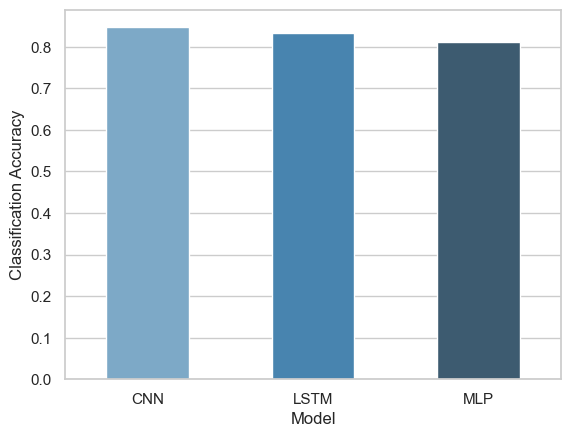

In [127]:
plot_model_metric(models, accuracies, 'Classification Accuracy')

### 9.2 Confusion matrix

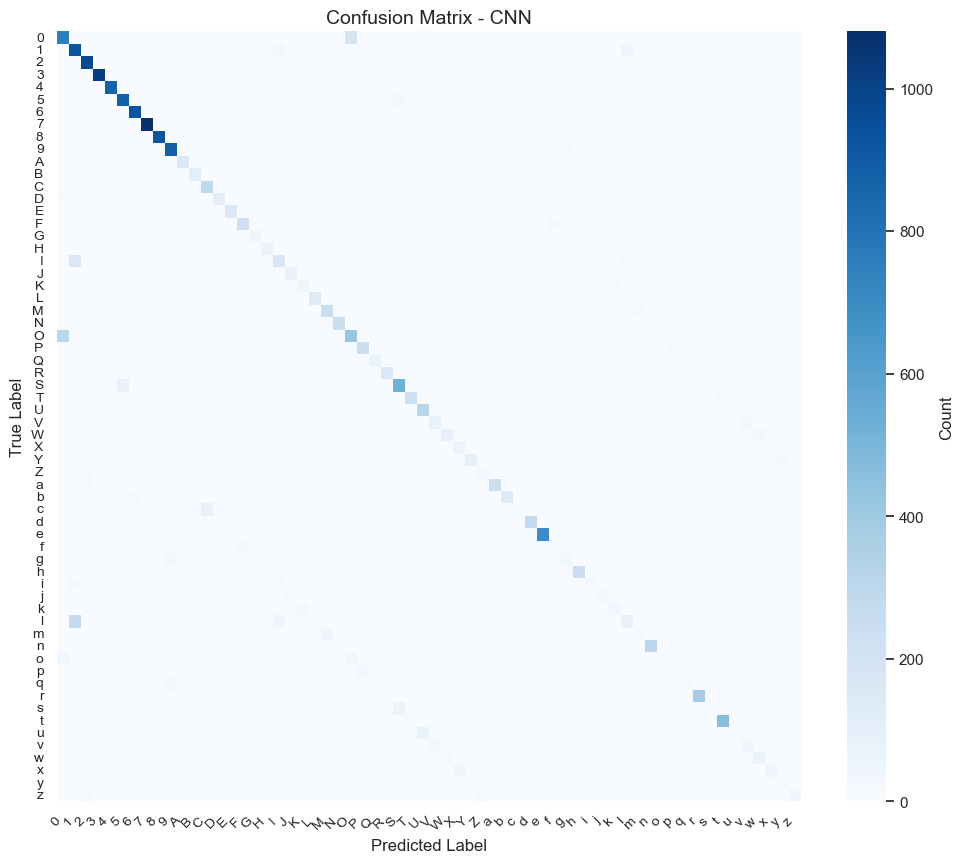

In [153]:
plot_confusion(confusion_matrix(y_test, y_pred_cnn), 'CNN')

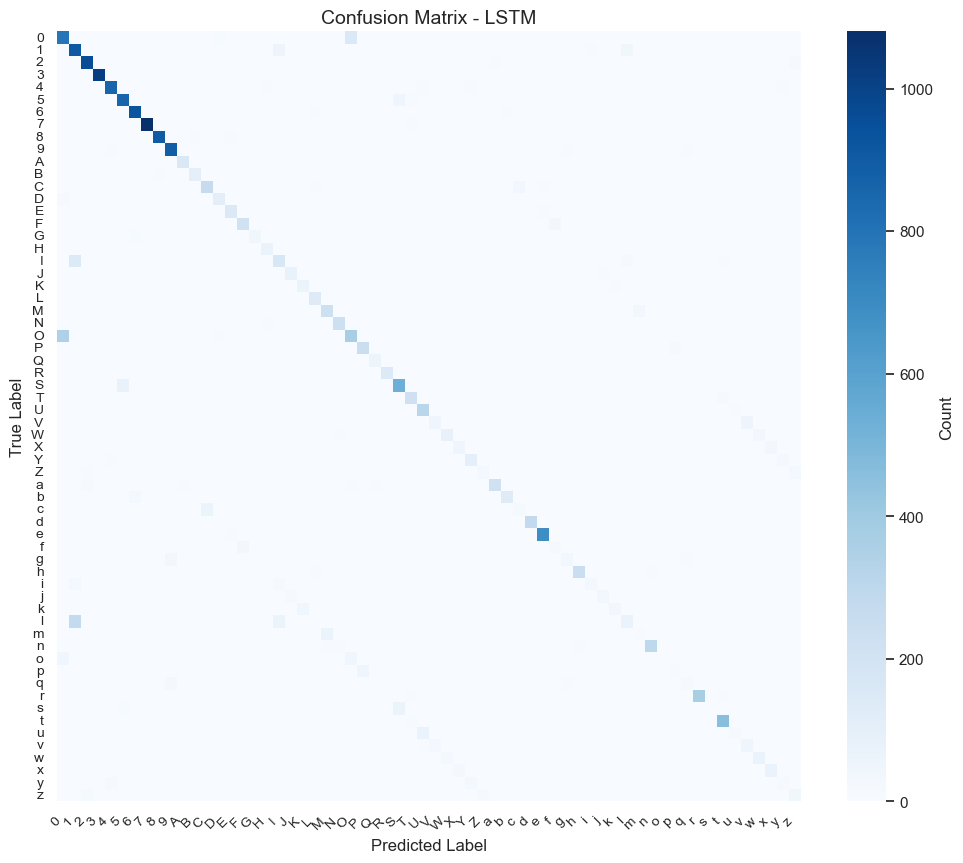

In [154]:
plot_confusion(confusion_matrix(y_test, y_pred_lstm), 'LSTM')

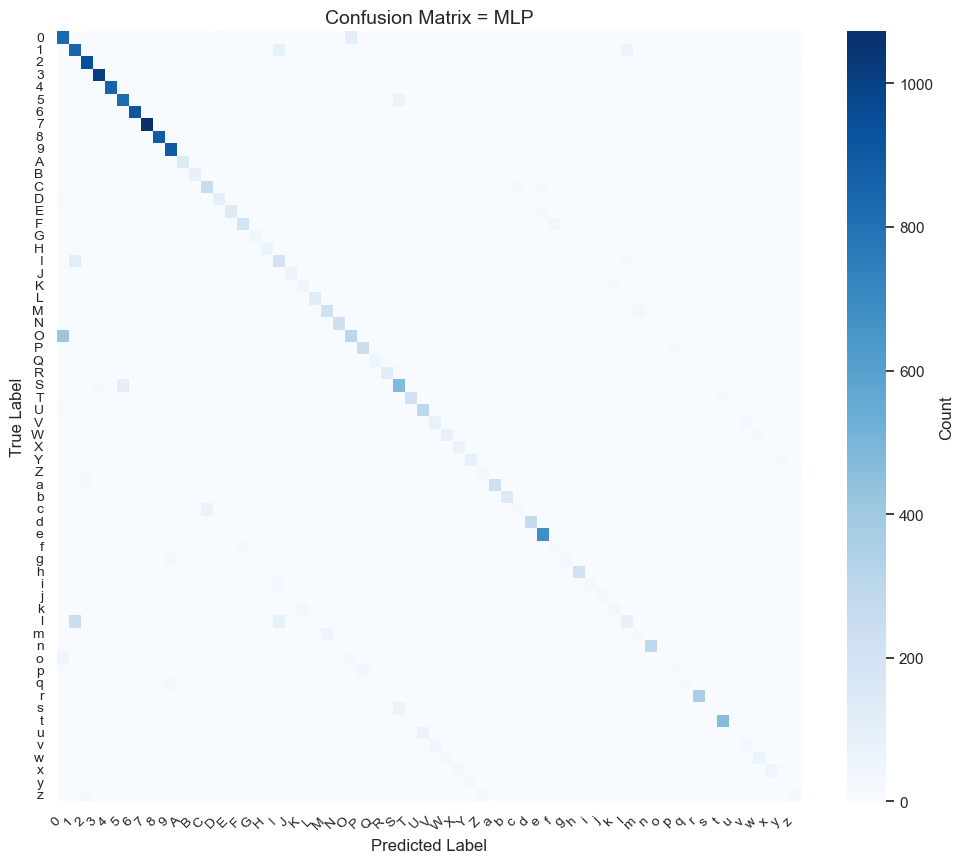

In [151]:
plot_confusion(confusion_matrix(y_test, y_pred_mlp), 'MLP')

#### 9.2 Testing Sample of Each Model

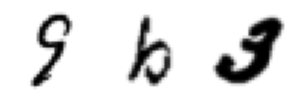

Actual Result:  ['9', 'b', '3']


In [160]:
X_test_sample = X_test[3:6]
y_test_sample = y_test[3:6]
plot_examples(X_test[3:], n_rows=1, n_cols=3)
print("Actual Result: ", [get_character_from_label(i) for i in y_test_sample])


In [164]:
print(X_test_sample.shape)

(3, 28, 28, 1)


In [161]:
# Get probability of each class from model
y_proba_cnn_sample = best_cnn.predict(X_test_sample)
y_pred_cnn_sample = np.argmax(y_proba_cnn_sample, axis=-1)

y_proba_lstm_sample = best_lstm.predict(X_test_sample)
y_pred_lstm_sample = np.argmax(y_proba_lstm_sample, axis=-1)

y_proba_mlp_sample = best_mlp.predict(X_test_sample)
y_pred_mlp_sample = np.argmax(y_proba_mlp_sample, axis=-1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [167]:
print("Classification result of CNN: ")
print([get_character_from_label(i) for i in y_pred_cnn_sample])
print("Classification result of LSTM: ")
print([get_character_from_label(i) for i in y_pred_lstm_sample])
print("Classification result of MLP: ")
print([get_character_from_label(i) for i in y_pred_mlp_sample])


Classification result of CNN: 
['9', 'h', '3']
Classification result of LSTM: 
['9', 'b', '3']
Classification result of MLP: 
['9', 'b', '3']
